# PeW Evolution with Phase

In [11]:
from pathlib import Path
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sndata.csp import DR1, DR3
from sndata.utils import convert_to_jd

results_dir = Path('.').resolve().parent / 'results'
features = dict(
  pW1='Ca ii H&',
  pW2='Si ii λ4130',
  pW3='Mg ii, Fe ii',
  pW4='Fe ii, Si ii',
  pW5='S ii λ5449, λ5622',
  pW6='Si ii λ5972',
  pW7='Si ii λ6355',
  pW8='Ca ii IR triplet'
)


## Reading in data

In [12]:
dr3 = DR3()
dr3.download_module_data()


In [13]:
@np.vectorize
def get_csp_t0(obj_id):
    """Get the t0 value for CSP targets

    Args:
        obj_id (str): The object identifier

    Returns:
        The time of B-band maximum in units of
    """

    csp_table_3 = dr3.load_table(3).to_pandas(index='SN')
    
    # Unknown object ID
    if obj_id not in csp_table_3.index:
        return np.nan

    t0_mjd = csp_table_3.loc[obj_id]['T(Bmax)']

    # Known object Id with unknown peak time
    if np.isnan(t0_mjd):
        return np.nan

    return convert_to_jd(t0_mjd)


def read_in_pipeline_result(path, drop_flagged=False):
    """Read pEW values from analysis pipline file
    
    Adds columns for Branch classifications determined by the
    measured pEW values and spectral subtypes determined from 
    CSP DR1.
    
    Args:
        path (str): Path of the file to read
        
    Returns:
        A pandas Dataframe indexed by feat_name and obj_id
    """
    
    df = pd.read_csv(path, index_col=['feat_name', 'obj_id'])

    # Add phases using CSP DR3 t0 values
    obj_id = df.index.get_level_values(1)
    df['phase'] = df.time - get_csp_t0(obj_id)

    csp_table_2 = dr3.load_table(2)
    subtypes = pd.DataFrame({'spec_type': csp_table_2['Subtype1']}, index=csp_table_2['SN'])
    df = df.join(subtypes, on='obj_id')
    
    if drop_flagged:
        df = df[(df.spec_flag != 1) & (df.feat_flag != 1)]
    
    return df



In [14]:
# Load CSP measurements and drop any flagged values
csp_final = read_in_pipeline_result(results_dir / 'final_csp.csv', drop_flagged=True)
csp_final = csp_final[csp_final.spec_type != '---']
csp_final.spec_type = csp_final.spec_type.replace('06gz-like', '91bg-like')


## Pew Vs. Phase

In [15]:
def plot_feat_evolution(feature_data, color_by='spec_type', kwargs=dict(), axis=None):
    """Plot the strength of a feature vs phase
    
    Args:
        feature_data (DataFrame): Dataframe to plot data from
        color_by           (str): Name of the column to color code points by
        kwargs      (dict[dict]): Plotting kwargs for each unique value in the `color_by` column
        axis              (Axis): Optionally plot on a given axis
    """
    
    if axis is None:
        fig, axis = plt.subplots(figsize=(6, 4))
    
    feature_data = feature_data.sort_values('phase')
    for i, (class_name, class_data) in enumerate(feature_data.groupby(color_by)):
        x = class_data.phase
        y = class_data.pew
        y_err = class_data.pew_samperr
        
        axis.errorbar(x, y, yerr=y_err, linestyle='', **kwargs.get(class_name, dict()))
        axis.scatter(x, y, s=10, label=class_name,  **kwargs.get(class_name, dict()))
    
    if axis is None:
        axis.set_xlabel('Phase', fontsize=12)
        axis.set_ylabel(r'pEW ($\AA$)', fontsize=12)
        
    axis.set_xlim(-15, 15)
    

In [18]:
def plot_all_features(df, color_by='spec_type', kwargs=dict()):
    """Plot pEW measurments vs. phase for all 8 features
    
    Args:
        df      (DataFrame): Dataframe to plot data from
        color_by      (str): Name of the column to color code points by
        kwargs (dict[dict]): Plotting kwargs for each unique value in the `color_by` column
    """
    
    plot_features = [f'pW{i}' for i in range(1, 9)]
    fig, axes = plt.subplots(4, 2, sharex=True, figsize=(7.5, 10))

    for axis, feature in zip(axes.flatten(), plot_features):
        feature_data = df.loc[feature]
        plot_feat_evolution(feature_data, color_by, axis=axis, kwargs=kwargs)
        axis.set_title(f'{features[feature]} ({feature})')

    for axis in axes[:, 0]:
        axis.set_ylabel('pEW', fontsize=12)
    
    for axis in axes[-1, :]:
        axis.set_xlabel('Phase', fontsize=12)
        
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), framealpha=1)
    
    plt.tight_layout()


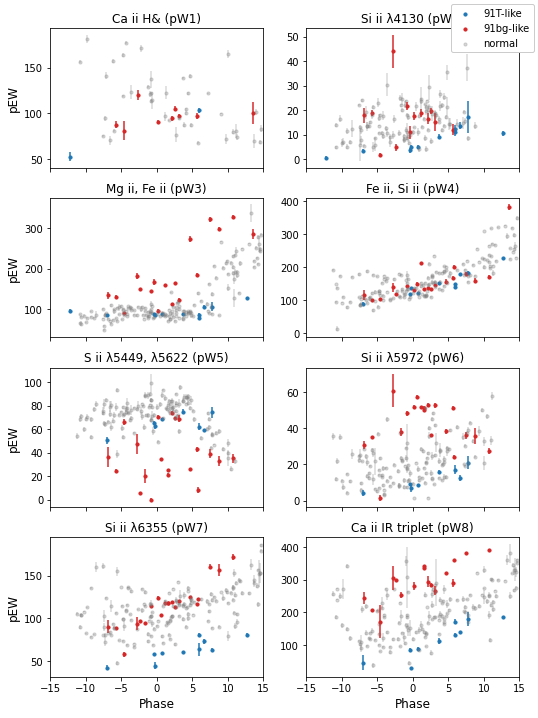

In [19]:
kwargs = {
    'normal': {'color': 'grey', 'alpha': .3},
    '91bg-like': {'color': 'C3'},
    '91T-like': {'color': 'C0'}
}

plot_all_features(csp_final, kwargs=kwargs)
plt.show()
